In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [63]:
from google.colab import drive
import os
drive.mount('/content/drive')
BASE_URL = '/content/drive/MyDrive/Colab Notebooks/MLT/owd'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# df_owd = pd.read_csv(os.path.join(BASE_URL,"data_stamet_ngurah_rai_pre.csv"), parse_dates=True)
df_owd = pd.read_csv("../src/dataset/data_stamet_ngurah_rai_pre.csv", parse_dates=True)
df_owd.rename(columns = {'Tanggal':'dt_iso', 'Tn':'temp_min_min', 
    'Tx':'temp_max_max', 'Tavg':'temp_mean', 'RH_avg':'humidity_mean', 
    'ff_avg':'wind_speed_mean', 'RR':'rain_1d'}, inplace = True)
df_owd['dt_iso'] = pd.to_datetime(df_owd['dt_iso'], format='%d-%m-%Y')
df_owd.head()

,dt_iso,temp_min_min,temp_max_max,temp_mean,humidity_mean,wind_speed_mean,rain_1d
0,1990-01-01,25.0,32.8,29.1,75.0,2.0,0.0
1,1990-01-02,26.0,31.0,26.4,86.0,1.0,0.0
2,1990-01-03,25.0,31.6,27.9,76.0,2.0,17.2
3,1990-01-04,25.0,30.8,28.0,81.0,2.0,34.8
4,1990-01-05,25.0,29.8,27.2,86.0,2.0,6.1


### Cleansing

Check nilai 8888 dan 9999. 8888 berarti tidak terbaca karena nilainya sangat kecil sedangkan 9999 biasanya dikarenakan alat rusak

In [3]:
print((df_owd == 8888).any())
print((df_owd == 9999).any())

dt_iso             False
temp_min_min       False
temp_max_max       False
temp_mean          False
humidity_mean      False
wind_speed_mean    False
rain_1d             True
dtype: bool
dt_iso             False
temp_min_min       False
temp_max_max       False
temp_mean          False
humidity_mean      False
wind_speed_mean    False
rain_1d            False
dtype: bool


Replace 8888 with 0

In [4]:
df_owd = df_owd.replace(8888, 0)

Check NaN value

In [5]:
print((df_owd.isna()).any())

dt_iso             False
temp_min_min        True
temp_max_max        True
temp_mean           True
humidity_mean       True
wind_speed_mean     True
rain_1d             True
dtype: bool


Replace NaN with mean di kolom yang bersangkutan

In [6]:
df_owd.fillna(df_owd.mean(), inplace = True)

c:\Users\azrina\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


## EDA

Pola curah hujan dalam satu tahun

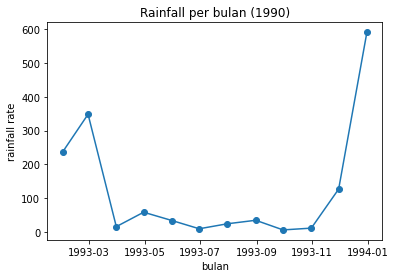

In [7]:
df_1993 = df_owd[(df_owd['dt_iso'] >= '1993-01-01') & (df_owd['dt_iso'] <= '1993-12-31')]
plt.plot(df_1993.groupby([pd.Grouper(key='dt_iso', freq='M')]).rain_1d.sum(), marker='o')
plt.title("Rainfall per bulan (1990)")
plt.ylabel("rainfall rate")
plt.xlabel("bulan")
plt.show()

Dari plot terlihat data mengikuti pola yang valid

- Denpasar mengikuti pola Monsoon, 
- Puncak musim hujan berada di **Dec-Jan-Feb (DJF)**
- Puncak musim kemarau berada di **Jun-Jul-Aug (JJA)**

<img src='../src/images/pola.jpeg'></img>

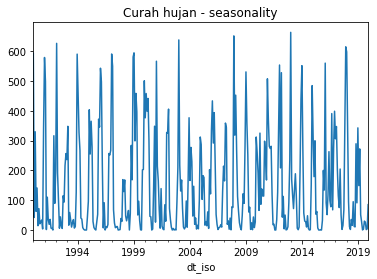

In [8]:
df_owd.groupby([pd.Grouper(key='dt_iso', freq='M')]).rain_1d.sum().plot()
plt.title('Curah hujan - seasonality')
plt.show()

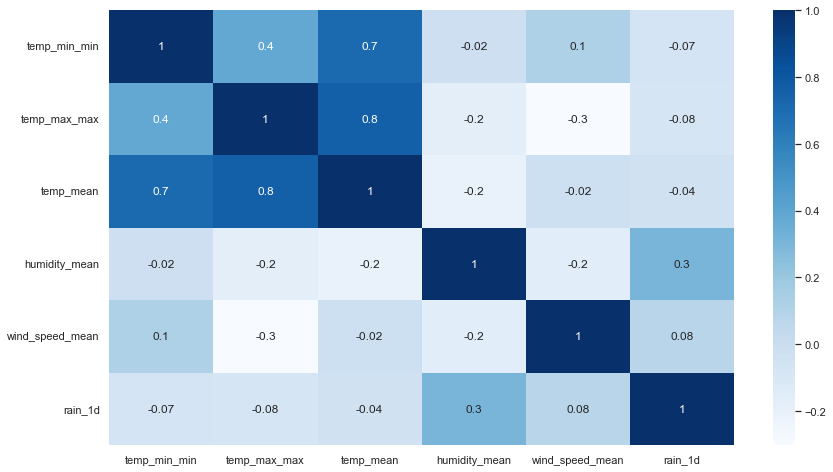

In [9]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = df_owd.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

Hasil korelasi parameter tidak ada korelasi yang kuat antara curah hujan dan parameter lainnya

Namun pada riset ini diangkut semua paramater karena parameter tersebut yang biasa dipakai dalam prediksi curah hujan

### Dataset Statistik

In [10]:
df_owd.describe()

,temp_min_min,temp_max_max,temp_mean,humidity_mean,wind_speed_mean,rain_1d
count,10957.000000,10957.000000,10957.000000,10957.000000,10957.000000,10957.000000
mean,24.632622,30.634704,27.203018,80.502927,3.086081,4.938395
std,1.380008,1.345982,1.184370,4.832626,1.372721,14.186706
min,18.000000,25.200000,21.700000,55.000000,0.000000,0.000000
25%,24.000000,29.700000,26.500000,78.000000,2.000000,0.000000
50%,25.000000,30.600000,27.300000,80.000000,3.000000,0.000000
75%,25.000000,31.600000,28.000000,84.000000,4.000000,2.000000
max,29.000000,35.200000,30.700000,99.000000,17.000000,231.400000


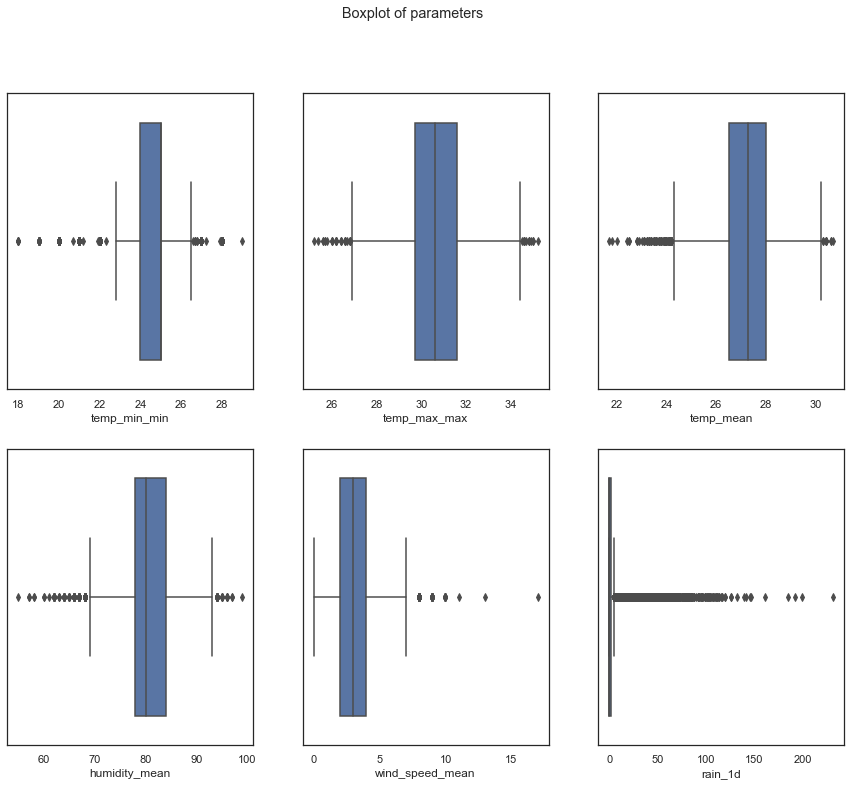

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(15, 12))
fig.suptitle('Boxplot of parameters')
i, j = 0, 0
for c in df_owd:
    if c != 'dt_iso':
        sns.boxplot(ax=axes[i, j], x=df_owd[c])

        j = j + 1
        if j >= 3:
            j = 0
            i = i + 1

Dari boxplot dapat dilihat bahwa yang mendekati distribusi normal hanyalah **temp_max**

Sehingga untuk keseragaman maka normalisasi tidak menggunakan z-score melainkan min-max,  

## Preprocess

In [12]:
df_owd_train = df_owd[(df_owd['dt_iso'] <= '2018-12-31')]
df_owd_test = df_owd[(df_owd['dt_iso'] >= '2019-01-01') & (df_owd['dt_iso'] <= '2019-12-31')]

In [13]:
df_owd = df_owd.set_index('dt_iso')
df_owd_train = df_owd_train.set_index('dt_iso')
df_owd_test = df_owd_test.set_index('dt_iso')

In [14]:
sc = MinMaxScaler(feature_range = (0, 1))
norm_df_owd = sc.fit_transform(df_owd_train)

### Windowing dataset

In [15]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [16]:
past_history = 365
future_target = 365
n_feature = 6
STEP = 1
TRAIN_SPLIT = 9861 # 2017
x_train_multi, y_train_multi = multivariate_data(norm_df_owd, norm_df_owd[:, 5], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(norm_df_owd, norm_df_owd[:, 5],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [17]:
print(x_train_multi.shape, x_val_multi.shape)
print(y_train_multi.shape, y_val_multi.shape)

(9496, 365, 6) (1, 365, 6)
(9496, 365) (1, 365)


## Model

In [140]:
model = keras.models.Sequential([
  keras.layers.Bidirectional(keras.layers.GRU(units=512, return_sequences = True, input_shape=(past_history, n_feature))),
  keras.layers.Dropout(0.2),
  keras.layers.Bidirectional(keras.layers.GRU(units=256)),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(units = future_target, activation='relu')
])

In [141]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [142]:
epoch = 40
batch_size = 128
model.fit(x_train_multi, y_train_multi, validation_data=(x_val_multi, y_val_multi), epochs = epoch, batch_size = batch_size)

Epoch 1/40
69/69 [==============================] - 58s 739ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 2/40
69/69 [==============================] - 51s 736ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 3/40
69/69 [==============================] - 51s 744ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 4/40
69/69 [==============================] - 51s 746ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 5/40
69/69 [==============================] - 51s 734ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 6/40
69/69 [==============================] - 51s 740ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 7/40
69/69 [==============================] - 51s 743ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 8/40
69/69 [==============================] - 52s 748ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 9/40
69/69 [==============================] - 51s 745ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 10/40
69/69 [==============================] - 52s 752ms/step - loss: 0.0036 - val_lo

In [160]:
model.save(os.path.join(BASE_URL,'model2.h5'))

### Testing dan Predict 2019

In [149]:
X_predict = norm_df_owd[-past_history:].reshape((-1, past_history, n_feature))

In [150]:
hasil = model.predict(X_predict)

Descaling / denormalisasi

In [151]:
max = sc.data_max_[-1]
min = sc.data_min_[-1]
y_descaled = hasil * (max - min) + min
# y_descaled

Concat dalam satu dataframe untuk kemudahan plotting dan kalkulasi

In [152]:
total_1d_predicted = pd.Series(y_descaled.flatten(), name='total_1d_predicted')

# df_owd_test = df_owd_test.reset_index()
aggregated_2019_df = pd.concat([df_owd_test, total_1d_predicted], axis=1)

In [153]:
rain_1M_2019 = aggregated_2019_df.groupby([pd.Grouper(key='dt_iso', freq='M')]).rain_1d.sum()
rain_1M_2019_pred = aggregated_2019_df.groupby([pd.Grouper(key='dt_iso', freq='M')]).total_1d_predicted.sum()

# (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
rain_1M_2019 = (rain_1M_2019 - min) / (max - min)
rain_1M_2019_pred = (rain_1M_2019_pred - min) / (max - min)
mse = ((rain_1M_2019_pred - rain_1M_2019) ** 2).sum() / 12
print(mse)

0.15422574003291367


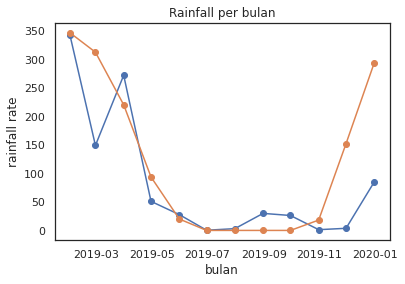

In [154]:
plt.plot(aggregated_2019_df.groupby([pd.Grouper(key='dt_iso', freq='M')]).rain_1d.sum(), marker='o')
plt.plot(aggregated_2019_df.groupby([pd.Grouper(key='dt_iso', freq='M')]).total_1d_predicted.sum(), marker='o')
plt.title("Rainfall per bulan")
plt.ylabel("rainfall rate")
plt.xlabel("bulan")
plt.show()

### Pecah per dasarian

In [155]:
df_M = aggregated_2019_df.groupby([pd.Grouper(key='dt_iso', freq='M')])

rain_10d, rain_10d_pred = [], []
for group_name, df_group in df_M:
    rain_10d.append(df_group["rain_1d"][0:10].sum())
    rain_10d.append(df_group["rain_1d"][10:20].sum())
    rain_10d.append(df_group["rain_1d"][20:].sum())
    rain_10d_pred.append(df_group["total_1d_predicted"][0:10].sum())
    rain_10d_pred.append(df_group["total_1d_predicted"][10:20].sum())
    rain_10d_pred.append(df_group["total_1d_predicted"][20:].sum())

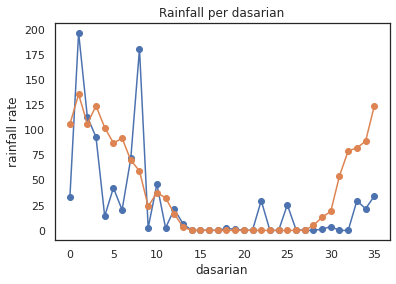

In [156]:
plt.plot(rain_10d, marker='o')
plt.plot(rain_10d_pred, marker='o')
plt.title("Rainfall per dasarian")
plt.ylabel("rainfall rate")
plt.xlabel("dasarian")
plt.show()

In [157]:
rain_10d_pred = np.array(rain_10d_pred)
rain_10d = np.array(rain_10d)

Thresholding ambang batas curah hujan, > 50mm menandakan musim hujan

In [158]:
np.where(rain_10d > 50)

(array([1, 2, 3, 7, 8]),)

In [159]:
np.where(rain_10d_pred > 50)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 31, 32, 33, 34, 35]),)